In [1]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.fit_model as fit_model

import torch
import pandas as pd
import random
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population

import torch
import pandas as pd
import random
from matplotlib import pyplot as plt
import networkx as nx

device = "cuda" if torch.cuda.is_available() else "cpu"


class EPI_dense2(torch.nn.Module):
    def __init__(self, ISNet, psMatrix, population, device, train=False, cc=None, recursive=False, sampleAsState=False):
        super(EPI_dense2, self).__init__()
        self._n= ISNet.size()[0]
        self._IS= ISNet
        self._EE= torch.eye(self._n).to(device)
        self._II= self._EE
        self._RR= self._EE
        self._state= torch.stack((population["S"], population["E"], population["I"], population["R"]))
        self._psMatrix= psMatrix
        self._train= train
        if train==True:
            self._psMatrix=torch.nn.Parameter(psMatrix)
        self._P= self._state
        self._forceCc=torch.tensor([[0, 1, 0, 0],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1],
                                    [0, 0, 0, 0]], device=device) 
        self._cc= cc
        self._recursive= recursive
        self._softmaxLayer= torch.nn.Softmax(dim=1)
        self._sampleAsState= sampleAsState
    
    def reset_population(self, population):
        self._state= torch.stack((population["S"], population["E"], population["I"], population["R"]))
        self._P= self._state

    def forward(self):
        stateGradient= None
        if self._recursive:
            stateGradient= self._state
        else:
            stateGradient= torch.clone(self._state)
        
        if self._train==False:
            psMatrix=self._psMatrix
        else:
            psMatrix= self._softmaxLayer(self._psMatrix)
            psMatrix= psMatrix*self._forceCc
            if self._cc is not None:
                psMatrix= psMatrix*self._cc
        
        L= torch.zeros_like(self._state, device=device)
        logBase= torch.log(1-psMatrix[0, 1])
        #L[0]= stateGradient[0]*torch.matmul(self._IS, stateGradient[2])
        st2= stateGradient[2][None, :]
        st0= stateGradient[0][:, None]
        tempL0= torch.log(1-self._IS*st0*st2*psMatrix[0, 1])
        L[0]= tempL0.sum(dim=1)/logBase
        #print((L[0]-stateGradient[0]*torch.matmul(self._IS, stateGradient[2])).sum())
        L[1]= torch.matmul(stateGradient[1], self._EE)
        L[2]= torch.matmul(stateGradient[2], self._II)
        L[3]= torch.matmul(stateGradient[3], self._RR)
        prob= 1- torch.exp(torch.matmul(torch.log(1 - psMatrix.T), L))
        print(torch.log(1 - psMatrix.T))
        print(L)
        print(prob)

        _stable_prob= 1- torch.sum(prob, 0)
        prob= prob+ stateGradient*_stable_prob
        print(prob)
        print()
        if self._train==False or self._recursive==False:
            with torch.no_grad():
                if self._sampleAsState:
                    self._state= self.sample_uniform_matrix(prob)
                else:
                    self._state= prob
                self._P= prob
        elif self._recursive==True:
            #state= self.sample_uniform_matrix(prob)
            self._state= prob#gradient disappearing here, consider only transfer probability?
            self._P= prob
        
        return torch.sum(self._state, 1), torch.sum(prob, 1), prob
    
    def get_population_num(self):

        return torch.sum(self._state, 1)

    #sample nxm pobability matrix, of 0 dimension, which contains n choise for a random variable
    def sample_uniform_matrix(self, P):  
        state= torch.zeros_like(P, device=device)
        U= torch.rand(self._n).to(device)
        for i in range(P.size()[0]):
            U= U- P[i]
            state[i]= U<0
            U= U+state[i]
        return state
    
    def get_population_dir(self):
        return { #a columnar DB somewhat reminds the Pandas DataFrame 
                "S": self._state[0],
                "E": self._state[1],
                "I": self._state[2],
                "R": self._state[3],
                }
    def get_population(self):
        return self._state
    
    def get_probability(self):
        return self._P
    
    def get_probability_transition_matrix(self):
        
        return self._psMatrix
    
    def get_psMatrix(self):
        #psMatrix= torch.sigmoid(self._psMatrix)
        psMatrix= self._softmaxLayer(self._psMatrix)
        if self._cc is not None:
                psMatrix= psMatrix*self._cc
        return psMatrix

In [17]:
def sim(timeHorizon, model: EPI_dense2):
  populationNumber= []
  populationExpectation= []
  for i in range(timeHorizon):
    populationNumberi, populationExpectationi, _= model()
    populationNumber.append(populationNumberi)
    populationExpectation.append(populationExpectationi)
  populationNumber = torch.stack(populationNumber)
  populationExpectation = torch.stack(populationExpectation)

  return populationNumber, populationExpectation

In [18]:
n= 9
avgDegree= 6
timeHorizon= 5
print("haha")
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
print("haha")
contact = contact.requires_grad_(True)
realData =None
with torch.no_grad():
    ps= torch.tensor([[0, 0.3, 0, 0],
                      [0, 0, 0.1, 0],
                      [0, 0, 0, 0.3],
                      [0, 0, 0, 0]], device=device)
    population= create_population.population(n, device)
    model= EPI_dense2(contact, ps, population, device)
    realData, _ =sim(timeHorizon, model)


haha
haha
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3567,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.1054,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.3567,  0.0000]], device='cuda:0')
tensor([[1., 1., 1., 1., 1., 1., 1., 1., -0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3000]],
       device='cuda:0')
tensor([[0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.0000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

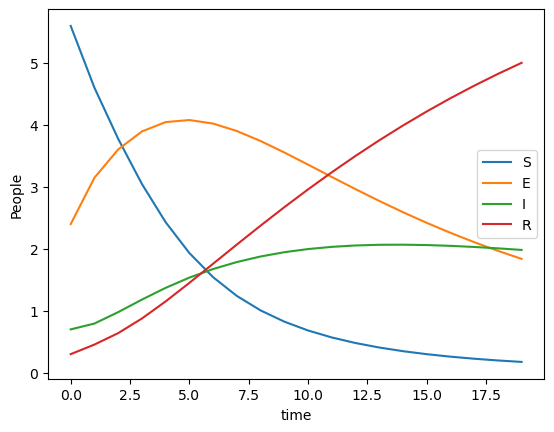

In [23]:
populationNumberPlot= realData.cpu().detach()
plt.plot(populationNumberPlot, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("People")
plt.legend()

In [16]:
realData.requires_grad_(True)
psFit= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
cc= torch.tensor([  [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [0, 0, 0, 0]], device=device)
populationFit= create_population.population(n, device)
modelFit= fit_model.EPI_dense(contact, psFit, populationFit, device, train=True, cc=cc, recursive=True)
lossFn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(modelFit.parameters(), lr=3e-1)

In [21]:
fitPinfs=[]
#1. choose a better optimiser
#2. bigmodel learn intrinsic, gradient easy model !!!
#3. adaptive constraint?
#4. GAN ?
losses= []
for i in tqdm(range(500)):
    optimizer.zero_grad()
    fitPinfs.append(modelFit.get_psMatrix())
    populationFit= create_population.population(n, device)
    modelFit.reset_population(populationFit)
    fitPopulation, expectation = sim(timeHorizon, modelFit)
    #loss= lossFn(expectation, realData)/n/timeHorizon
    loss= lossFn(expectation[:, 2], realData[:, 2])/n/timeHorizon
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
print(modelFit.get_psMatrix())

 17%|█▋        | 83/500 [00:05<00:26, 15.94it/s]


KeyboardInterrupt: 

tensor([[0.0000, 0.0145, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0198, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8816],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)
None
10.517037391662598


/tmp/ipykernel_24288/2677378229.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1670027390539/work/build/aten/src/ATen/core/TensorBody.h:480.)
  print(loss.grad)


Text(0, 0.5, 'loss')

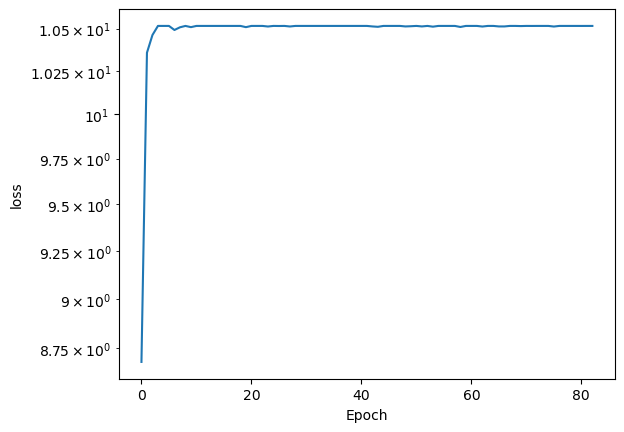

In [22]:
print(modelFit.get_psMatrix())
print(loss.grad)
print(loss.item())
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("loss")

In [10]:
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 3.9847, -3.9848,  3.9847,  3.9847],
        [-0.0087, -0.0087,  0.0087, -0.0087],
        [-0.6756, -0.6756, -0.6756,  0.6756],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[-2.4906e-11,  7.4719e-11, -2.4906e-11, -2.4906e-11],
        [-2.1576e-11, -2.1576e-11,  6.4729e-11, -2.1576e-11],
        [ 2.3821e-06,  2.3821e-06,  2.3821e-06, -7.1463e-06],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0')
---------------------------------


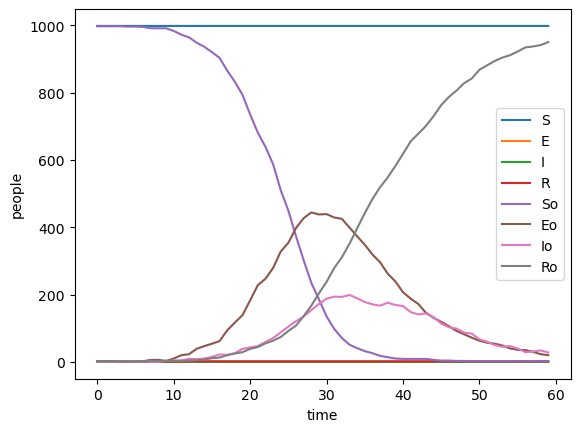

In [23]:
populationNumberPlot2= fitPopulation.cpu().detach()
plt.plot(populationNumberPlot2, label=['S', 'E', 'I', 'R'])
plt.plot(populationNumberPlot, label=['So', 'Eo', 'Io', 'Ro'])
plt.xlabel("time")
plt.ylabel("people")
plt.legend()